In [1]:
%load_ext watermark
%watermark -a Filippo_Valle -p pandas,scanpy,requests,numpy -m -v -g

Author: Filippo_Valle

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.27.0

pandas  : 1.3.3
scanpy  : 1.8.1
requests: 2.26.0
numpy   : 1.19.5

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.13.0-27-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: b88f10dbba2e53f9134a5fed050c6eb75f9e1e96



In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import json
import requests

# Preprocessing

## Gene Names

In [3]:
df_conversion = pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&col=md_ensembl_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", sep="\t").set_index("Approved symbol")
df_conversion.rename(columns={"Ensembl ID(supplied by Ensembl)":"ensg"}, inplace=True)
df_conversion.head(2)

,ensg
Approved symbol,
A1BG,ENSG00000121410
A1BG-AS1,ENSG00000268895


## bioMART
https://www.ensembl.org/biomart/martview/cf9b27b6e78e9d6a1be079a4ea60f7fe

In [4]:
df_mart = pd.read_csv("mart_export.txt").set_index("Gene stable ID")
df_mart.head(2)

,miRBase ID,Gene type
Gene stable ID,,
ENSG00000210049,NaN,Mt_tRNA
ENSG00000211459,NaN,Mt_rRNA


# Tables

## TCGA FPKM

In [5]:
df_tcga = pd.read_csv("mainTable_fpkm.csv", sep=",", index_col=0)
df_tcga = df_tcga.transpose().drop_duplicates().transpose()
df_tcga.head(2)

,TCGA-44-7667-01A-31R-2066-07,TCGA-22-4594-01A-01R-1201-07,TCGA-52-7811-01A-11R-2125-07,TCGA-63-A5MS-01A-11R-A26W-07,TCGA-93-A4JP-01A-11R-A24X-07,TCGA-60-2716-01A-01R-0851-07,TCGA-75-6211-01A-11R-1755-07,TCGA-NC-A5HM-01A-12R-A26W-07,TCGA-55-8302-01A-11R-2326-07,TCGA-73-7498-01A-12R-2187-07,...,TCGA-44-7669-01A-21R-2066-07,TCGA-22-5472-11A-11R-1635-07,TCGA-62-A46R-01A-11R-A24H-07,TCGA-56-7222-11A-01R-2045-07,TCGA-55-7725-01A-11R-2170-07,TCGA-22-4595-01A-01R-1201-07,TCGA-73-4666-01A-01R-1206-07,TCGA-37-4135-01A-01R-1100-07,TCGA-66-2782-01A-01R-0851-07,TCGA-85-A4QQ-01A-41R-A262-07
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,37.12,47.74,28.10,45.74,26.06,23.00,39.57,85.32,24.03,20.80,...,36.90,16.42,32.17,22.94,30.97,33.00,23.7,84.46,35.88,38.67
ENSG00000000457,2.29,3.99,2.11,2.71,3.26,3.04,2.85,1.38,1.96,4.19,...,2.96,2.15,3.41,2.23,5.05,3.31,2.8,5.07,2.85,1.59


In [6]:
# isolate pc
df_tcga = df_tcga.join(df_mart, how="inner")
df_tcga = df_tcga[df_tcga["Gene type"]=="protein_coding"]
df_tcga = df_tcga.drop(["miRBase ID", "Gene type"],1)
cases = ["-".join(case.split("-")[:5]) for case in df_tcga.columns]
analytes = ["-".join(case.split("-")[:6]) for case in df_tcga.columns]
df_tcga.head(2)

/tmp/ipykernel_36681/1171779299.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_tcga = df_tcga.drop(["miRBase ID", "Gene type"],1)


,TCGA-44-7667-01A-31R-2066-07,TCGA-22-4594-01A-01R-1201-07,TCGA-52-7811-01A-11R-2125-07,TCGA-63-A5MS-01A-11R-A26W-07,TCGA-93-A4JP-01A-11R-A24X-07,TCGA-60-2716-01A-01R-0851-07,TCGA-75-6211-01A-11R-1755-07,TCGA-NC-A5HM-01A-12R-A26W-07,TCGA-55-8302-01A-11R-2326-07,TCGA-73-7498-01A-12R-2187-07,...,TCGA-44-7669-01A-21R-2066-07,TCGA-22-5472-11A-11R-1635-07,TCGA-62-A46R-01A-11R-A24H-07,TCGA-56-7222-11A-01R-2045-07,TCGA-55-7725-01A-11R-2170-07,TCGA-22-4595-01A-01R-1201-07,TCGA-73-4666-01A-01R-1206-07,TCGA-37-4135-01A-01R-1100-07,TCGA-66-2782-01A-01R-0851-07,TCGA-85-A4QQ-01A-41R-A262-07
ENSG00000000419,37.12,47.74,28.10,45.74,26.06,23.00,39.57,85.32,24.03,20.80,...,36.90,16.42,32.17,22.94,30.97,33.00,23.7,84.46,35.88,38.67
ENSG00000000457,2.29,3.99,2.11,2.71,3.26,3.04,2.85,1.38,1.96,4.19,...,2.96,2.15,3.41,2.23,5.05,3.31,2.8,5.07,2.85,1.59


In [8]:
df_files = pd.read_csv("files_tcga.dat") #rename files.dat just after having run TCGA_GetManifest.ipynb
df_files = df_files[df_files["sample_submitter_id"].isin(df_tcga.columns)]
df_files = df_files.loc[df_files.index[~df_files["sample_submitter_id"].duplicated(keep="first")],:]
df_files = df_files.set_index(df_files.columns[0])
df_files.head()

,file_miRNA,cases.0.demographic.days_to_birth,cases.0.demographic.days_to_death,cases.0.demographic.gender,cases.0.demographic.vital_status,cases.0.diagnoses.0.age_at_diagnosis,cases.0.diagnoses.0.days_to_last_follow_up,cases.0.diagnoses.0.last_known_disease_status,cases.0.exposures.0.cigarettes_per_day,cases.0.exposures.0.years_smoked,...,sample_submitter_id_mirna_type,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
cases.0.submitter_id,,,,,,,,,,,,,,,,,,,,,
TCGA-55-7726,03f54564-65bb-4561-ad33-ec78b883c217.mirbase21...,-26451.0,NaN,female,Alive,26451.0,652.0,not reported,1.643836,24.0,...,normal,LUAD,NaN,low,NaN,NaN,NaN,6.0,NaN,LUAD.6
TCGA-44-7672,28aeff63-ff53-417c-868c-156b9ee973c9.mirbase21...,-19200.0,NaN,female,Alive,19200.0,719.0,not reported,1.095890,NaN,...,tumor,LUAD,NaN,intermediate,NaN,NaN,NaN,6.0,NaN,LUAD.6
TCGA-50-5072,736f7d76-a7af-4d67-be9c-d7f94d568474.mirbase21...,-27036.0,250.0,male,Dead,27036.0,246.0,not reported,0.821918,NaN,...,tumor,LUAD,NaN,low,NaN,NaN,NaN,6.0,NaN,LUAD.6
TCGA-05-4425,3efaf7a3-ffcb-42d1-bd80-ebb7cf87b2a5.mirbase21...,-25902.0,NaN,female,Alive,25902.0,669.0,not reported,1.534247,NaN,...,tumor,LUAD,NaN,high,NaN,NaN,NaN,4.0,NaN,LUAD.4
TCGA-69-A59K,089c5bc7-08b0-47c9-8ddd-e3c006e6b063.mirbase21...,-22093.0,NaN,female,Alive,22093.0,591.0,not reported,1.369863,13.0,...,tumor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### HVG

In [9]:
adata = sc.AnnData(
    X=df_tcga.transpose().reindex(index=df_files["sample_submitter_id"]), 
    obs=df_files.set_index("sample_submitter_id"))

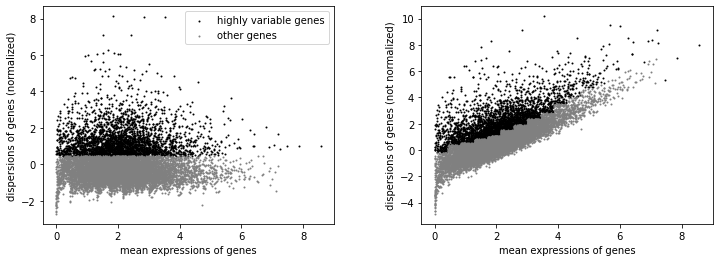

In [10]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)

In [11]:
hvg = adata.var[adata.var["highly_variable"]==True].index

## miRNA

In [12]:
df_tcga_mirna = pd.read_csv("mainTable_mirna.csv", index_col=0)
df_tcga_mirna = df_tcga_mirna.transpose().drop_duplicates().transpose()
mirna_submitter_ids = ["-".join(case.split("-")[:4]) for case in df_tcga_mirna.columns]
df_tcga_mirna.head(2)

,TCGA-LA-A446-01A-21H-A25B-13,TCGA-69-7760-01A-11H-2169-13,TCGA-91-6831-01A-11H-1857-13,TCGA-55-A48Y-01A-11H-A24G-13,TCGA-05-4417-01A-22H-1857-13,TCGA-86-7954-01A-11H-2186-13,TCGA-55-8616-01A-11H-2402-13,TCGA-50-6595-01A-12H-1857-13,TCGA-44-5643-01A-01T-1627-13,TCGA-05-5715-01A-01T-1627-13,...,TCGA-77-A5G6-01A-11H-A27R-13,TCGA-50-5068-01A-01T-1627-13,TCGA-44-2657-11A-01R-1757-13,TCGA-67-4679-01B-01T-1754-13,TCGA-77-8139-01A-11H-2246-13,TCGA-85-6798-01A-11H-1948-13,TCGA-63-A5MN-01A-22H-A27R-13,TCGA-MP-A5C7-01A-11H-A263-13,TCGA-50-5066-02A-11H-2089-13,TCGA-MP-A4SV-01A-11H-A24S-13
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,35590,22731,63331,17317,21866,38088,40056,34370,26821,94154,...,16768,178411,20204,29266,26583,55118,30100,48626,25621,19826
hsa-let-7a-2,35353,22716,63298,17129,22432,38283,40154,34122,26727,93435,...,16751,177379,20081,29141,26625,54972,29865,48393,25868,19959


### Highly variable miRNA

In [13]:
adata = sc.AnnData(
    X=df_tcga_mirna.transpose().reindex(index=df_files[df_files["sample_submitter_id_mirna"].isin(df_tcga_mirna.columns)]["sample_submitter_id_mirna"]), 
    obs=df_files[df_files["sample_submitter_id_mirna"].isin(df_tcga_mirna.columns)].set_index("sample_submitter_id_mirna"))

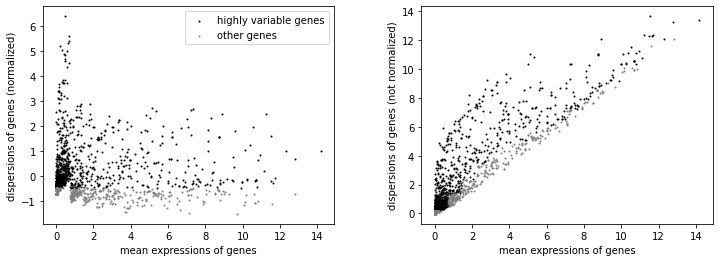

In [14]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
sc.pl.highly_variable_genes(adata)

In [15]:
hvmiRNA = adata.var[adata.var["highly_variable"]==True].index.unique()

In [16]:
df_files[["sample_submitter_id", "sample_submitter_id_mirna"]]

,sample_submitter_id,sample_submitter_id_mirna
cases.0.submitter_id,,
TCGA-55-7726,TCGA-55-7726-01A-11R-2170-07,TCGA-55-7726-11A-01H-2169-13
TCGA-44-7672,TCGA-44-7672-01A-11R-2066-07,TCGA-44-7672-01A-11H-2065-13
TCGA-50-5072,TCGA-50-5072-01A-21R-1858-07,TCGA-50-5072-01A-21H-1857-13
TCGA-05-4425,TCGA-05-4425-01A-01R-1755-07,TCGA-05-4425-01A-01T-1754-13
TCGA-69-A59K,TCGA-69-A59K-01A-11R-A262-07,TCGA-69-A59K-01A-11H-A263-13
...,...,...
TCGA-22-4599,TCGA-22-4599-01A-01R-1443-07,NaN
TCGA-39-5016,TCGA-39-5016-01A-01R-1443-07,NaN
TCGA-21-1071,TCGA-21-1071-01A-01R-0692-07,NaN


In [17]:
df_tcga_mirna = df_tcga_mirna.reindex(columns=df_files["sample_submitter_id_mirna"])
df_tcga_mirna.columns = df_files.index
df_tcga = df_tcga.reindex(columns=df_files["sample_submitter_id"])
df_tcga.columns = df_files.index

In [18]:
df_all = df_tcga.reindex(index=hvg, columns=df_files.index).append(df_tcga_mirna.reindex(index=hvmiRNA))
df_all

cases.0.submitter_id,TCGA-55-7726,TCGA-44-7672,TCGA-50-5072,TCGA-05-4425,TCGA-69-A59K,TCGA-69-7761,TCGA-44-A47G,TCGA-78-8662,TCGA-97-A4M0,TCGA-44-8120,...,TCGA-73-4666,TCGA-55-6975,TCGA-73-4668,TCGA-18-4083,TCGA-73-4677,TCGA-22-4599,TCGA-39-5016,TCGA-21-1071,TCGA-22-1002,TCGA-18-3409
ENSG00000000938,3.58,13.00,4.04,6.60,9.87,8.43,16.28,2.13,6.83,4.64,...,6.85,14.56,3.86,3.04,3.80,7.38,3.39,5.27,11.60,6.82
ENSG00000000971,22.16,9.31,7.09,21.59,5.34,60.66,20.65,21.25,12.58,31.16,...,26.44,14.44,4.22,3.92,7.47,7.47,12.93,14.95,20.48,9.92
ENSG00000001084,7.67,2.45,53.65,7.54,33.84,7.88,18.25,9.48,0.87,3.87,...,11.10,1.33,19.71,32.55,37.96,57.56,75.72,67.91,14.82,9.97
ENSG00000001561,2.62,4.24,4.94,10.00,7.82,13.09,7.87,58.12,9.57,24.93,...,7.23,14.77,10.76,1.30,14.80,2.04,2.15,4.03,4.82,3.04
ENSG00000001617,9.10,9.95,5.44,9.40,7.29,3.66,3.19,11.04,1.13,9.70,...,4.40,5.15,7.95,8.30,2.97,6.62,5.60,12.18,15.73,10.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-943,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hsa-mir-944,10.00,3.00,10.00,210.00,1.00,8.00,30.00,241.00,5.00,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hsa-mir-9500,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hsa-mir-99a,1745.00,427.00,1587.00,3525.00,974.00,510.00,2078.00,3228.00,888.00,3179.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_files.groupby(["cancer.type", "sample_submitter_id_type", "Subtype_Selected"]).count()

file_miRNA  \
cancer.type     sample_submitter_id_type Subtype_Selected               
Discordant_LUSC tumor                    LUSC.primitive             2   
                                         LUSC.secretory             4   
LUAD            normal                   LUAD.1                     1   
                                         LUAD.2                     2   
                                         LUAD.3                     2   
                                         LUAD.4                     5   
                                         LUAD.5                     5   
                                         LUAD.6                     2   
                tumor                    LUAD.1                    21   
                                         LUAD.2                    30   
                                         LUAD.3                    49   
                                         LUAD.4                    27   
                                         LUAD.5                    47   
                                         LUAD.6                    39   
LUSC            normal                   LUSC.classical             3   
                                         LUSC.primitive             1   
                                         LUSC.secretory             3   
                tumor                    LUSC.basal                38   
                                         LUSC.classical            59   
                                         LUSC.primitive            20   
                                         LUSC.secretory            32   

                                                           cases.0.demographic.days_to_birth  \
cancer.type     sample_submitter_id_type Subtype_Selected                                      
Discordant_LUSC tumor                    LUSC.primitive                                    2   
                                         LUSC.secretory                                    3   
LUAD            normal                   LUAD.1                                            1   
                                         LUAD.2                                            2   
                                         LUAD.3                                            2   
                                         LUAD.4                                            3   
                                         LUAD.5                                            5   
                                         LUAD.6                                            2   
                tumor                    LUAD.1                                           21   
                                         LUAD.2                                           24   
                                         LUAD.3                                           47   
                                         LUAD.4                                           26   
                                         LUAD.5                                           39   
                                         LUAD.6                                           34   
LUSC            normal                   LUSC.classical                                    3   
                                         LUSC.primitive                                    1   
                                         LUSC.secretory                                    3   
                tumor                    LUSC.basal                                       38   
                                         LUSC.classical                                   58   
                                         LUSC.primitive                                   19   
                                         LUSC.secretory                                   32   

                                                           cases.0.demographic.days_to_death  \
cancer.type     sample_submitter_id_type Subtype_Selected                 

# Fit

## hSBM

In [24]:
import sys
sys.path.append("../../hSBM_Topicmodel/")
from sbmtm import sbmtm

In [25]:
hsbm = sbmtm()
hsbm.make_graph_from_BoW_df(df_tcga.reindex(index=hvg).applymap(lambda fpkm: np.log2(fpkm+1)))

In [26]:
hsbm.g

<Graph object, undirected, with 4016 vertices and 2396604 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f066bf37190>

In [32]:
hsbm.save_graph("graph_lung_hsbm.xml.gz")

## triSBM

In [28]:
from trisbm import trisbm

In [29]:
trisbm_model = trisbm()
trisbm_model.make_graph(df_all.applymap(lambda fpkm: np.log2(fpkm+1)), lambda gene: 1 if "ENSG" in gene else 2)

In [30]:
trisbm_model.save_graph("graph_lung_trisbm.xml.gz")

In [31]:
np.isin(hsbm.words, trisbm_model.words).sum()

3000

# Consistency check

In [ ]:
import os

In [ ]:
trisbm_model = trisbm()
hsbm = sbmtm()

trisbm_model.load_graph("trisbm/graph.xml.gz")
hsbm.load_graph("topsbm/graph.xml.gz")

In [ ]:
import graph_tool.all as gt

In [ ]:
gt.adjacency(hsbm.g, weight=hsbm.g.ep["count"]).max()

In [ ]:
gt.adjacency(trisbm_model.g, weight=trisbm_model.g.ep["count"]).max()

In [ ]:
import numpy as np
np.isin(hsbm.words, trisbm_model.words, invert=False).sum()

In [ ]:
print(len(trisbm_model.words))
print(len(hsbm.words))

In [ ]:
print(trisbm_model.g.num_vertices(), trisbm_model.g.num_edges())
print(hsbm.g.num_vertices(), hsbm.g.num_edges())

In [ ]:
print(len(trisbm_model.documents), len(trisbm_model.words), len(trisbm_model.keywords[0]))
print(len(hsbm.documents), len(hsbm.words))